In [1]:
!pip install -U  --quiet langchain_community langchain-cohere  langchain-core  tiktoken langchain-openai langchainhub b langchain langgraph tavily-python newsapi-python
 


In [1]:
!pip install eventregistry -q

In [2]:
from eventregistry import *
er = EventRegistry(apiKey = news_client_id, allowUseOfArchive=False)
er

In [4]:
import os
from typing import Annotated, Literal, Dict, List, Tuple, Any
from langchain_openai import OpenAI, ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.utilities import SQLDatabase
from langchain_core.tools import tool
from langchain.agents import create_sql_agent
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.graph.message import AnyMessage, add_messages
from typing_extensions import TypedDict
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks


## Creating  sql agent


In [34]:
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)


db_loc = "stock_db.db"
db = SQLDatabase.from_uri(f"sqlite:///{db_loc}")
database_schema = db.get_table_info()

In [35]:
print(db.dialect)
print(db.get_usable_table_names())


sqlite
['assets_liabilities', 'fundamentals', 'industry_pe_ratios', 'industry_ticker_mapping', 'price', 'price_fundamentals', 'ratios', 'revenue_profit', 'technicals']


In [151]:
db.run("SELECT ipr.pe_ratio FROM industry_pe_ratios ipr JOIN industry_ticker_mapping itm ON ipr.industry = itm.industry WHERE itm.ticker = 'MSFT'")

'[(33.68,)]'

In [141]:
# from langchain_community.agent_toolkits import SQLDatabaseToolkit

# toolkit = SQLDatabaseToolkit(db=db, llm=llm)
# tools = toolkit.get_tools()

# list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
# get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

# print(list_tables_tool.invoke(""))

# print(get_schema_tool.invoke("fundamentals"))

In [172]:

# Create SQL toolkit and tools
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

# Define the state
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# Define system prompts
ANALYZE_PROMPT = """You are a financial data SQL expert. Analyze the user's question to determine which tables contain relevant information.

Available tables: {tables}
Schema information: {schema}

Guidelines:
1. For financial metrics, always check both 'fundamentals' and 'price' tables
2. For company analysis, consider historical data patterns
3. Map common company names to tickers:
   - Apple/AAPL
   - Microsoft/MSFT
   - Google/GOOGL
   - Amazon/AMZN
   - Tesla/TSLA

Return ONLY the relevant table names separated by commas, nothing else."""

QUERY_PROMPT = """You are a SQL expert. Use the following schema to help answer questions:
{schema}

Given an input question, create a syntactically correct SQLite query that joins the relevant tables.
IMPORTANT: 
- Return ONLY the SQL query without any markdown formatting or explanation
- Only query for relevant columns, not all columns
- Current date is 2022-09-30
- When company names are mentioned, map them to their correct ticker symbols:
  * Microsoft or microsoft -> MSFT
  * Apple or apple -> AAPL
  * Google or google -> GOOGL
  * etc.
- Always include appropriate WHERE clauses to filter for the specific company mentioned

DO NOT:
- Use markdown formatting (no ```sql or ``` tags)
- Make any DML statements (INSERT, UPDATE, DELETE, DROP etc.)
- Include any explanations before or after the query
- Default to AAPL or any other company if a specific company is mentioned
"""

# VALIDATION_PROMPT = """Validate this SQL query for common mistakes:
# {query}

# Schema:
# {schema}

# Check for:
# - Proper table joins
# - Correct column names
# - Appropriate WHERE clauses
# - Proper data type handling
# - SQL injection prevention

# Return ONLY the corrected query if needed, or the original query if valid.
# DO NOT include any markdown formatting or explanations."""

def clean_sql_query(query: str) -> str:
    """Remove markdown formatting and clean the SQL query"""
    # Remove markdown SQL markers
    query = query.replace("```sql", "").replace("```", "")
    # Remove any leading/trailing whitespace
    query = query.strip()
    return query



# Define node functions
def analyze_question(state: State) -> dict:
    """Analyze the question to determine relevant tables"""
    try:
        messages = state["messages"]
        question = messages[-1].content if messages else ""
        
        tables = list_tables_tool.invoke("")
        schema = db.get_table_info()
        
        messages = [
            SystemMessage(content=ANALYZE_PROMPT.format(tables=tables, schema=schema)),
            HumanMessage(content=question)
        ]
        
        analysis = llm.invoke(messages)
        
        return {
            "messages": state["messages"] + [AIMessage(content=str(analysis.content))]
        }
    except Exception as e:
        print(f"Error in analyze_question: {str(e)}")
        return {
            "messages": state["messages"] + [AIMessage(content=f"Error in analysis: {str(e)}")]
        }

def get_schemas(state: State) -> dict:
    """Get schemas for relevant tables"""
    try:
        messages = state["messages"]
        tables = messages[-1].content.split(",")
        schemas = []
        for table in tables:
            table = table.strip()
            schema = get_schema_tool.invoke(table)
            schemas.append(schema)
        
        return {
            "messages": state["messages"] + [AIMessage(content="\n".join(schemas))]
        }
    except Exception as e:
        print(f"Error in get_schemas: {str(e)}")
        return {
            "messages": state["messages"] + [AIMessage(content=f"Error getting schemas: {str(e)}")]
        }

def generate_query(state: State) -> dict:
    """Generate SQL query based on schemas and question"""
    try:
        question = state["messages"][0].content
        schemas = state["messages"][-1].content
        
        messages = [
            SystemMessage(content=QUERY_PROMPT.format(schema=schemas)),
            HumanMessage(content=question)
        ]
        
        query = llm.invoke(messages)
        # Clean the query before returning
        cleaned_query = clean_sql_query(query.content)
        
        return {
            "messages": state["messages"] + [AIMessage(content=cleaned_query)]
        }
    except Exception as e:
        print(f"Error in generate_query: {str(e)}")
        return {
            "messages": state["messages"] + [AIMessage(content=f"Error generating query: {str(e)}")]
        }

def validate_query(state: State) -> dict:
    """Validate and potentially correct the SQL query"""
    try:
        query = state["messages"][-1].content
        schema = db.get_table_info()
        
        messages = [
            SystemMessage(content="""Validate this SQL query and return ONLY the corrected query with NO additional text or explanation:
{query}

Schema:
{schema}

Check for:
- Proper table joins
- Correct column names
- Appropriate WHERE clauses
- Proper data type handling
- SQL injection prevention
- DO NOT modify any ticker symbols in WHERE clauses""".format(query=query, schema=schema)),
            HumanMessage(content=query)
        ]
        
        validated = llm.invoke(messages)
        # Clean the validated query before returning
        cleaned_query = clean_sql_query(validated.content)
        
        # Verify the ticker hasn't been changed
        if "WHERE" in query and "WHERE" in cleaned_query:
            original_ticker = query.split("WHERE")[1].strip().split("=")[1].strip()
            validated_ticker = cleaned_query.split("WHERE")[1].strip().split("=")[1].strip()
            if original_ticker != validated_ticker:
                return {
                    "messages": state["messages"] + [AIMessage(content=query)]  # Return original query
                }
        
        return {
            "messages": state["messages"] + [AIMessage(content=cleaned_query)]
        }
    except Exception as e:
        print(f"Error in validate_query: {str(e)}")
        return {
            "messages": state["messages"] + [AIMessage(content=f"Error validating query: {str(e)}")]
        }
    

def execute_query(state: State) -> dict:
    """Execute the SQL query"""
    try:
        query = state["messages"][-1].content
        # Make sure the query is clean before execution
        clean_query = clean_sql_query(query)
        result = db.run(clean_query)
        return {
            "messages": state["messages"] + [AIMessage(content=str(result))]
        }
    except Exception as e:
        print(f"Error in execute_query: {str(e)}")
        return {
            "messages": state["messages"] + [AIMessage(content=f"Error executing query: {str(e)}")]
        }

def format_results(state: State) -> dict:
    """Format the query results into a readable response"""
    try:
        # Find the SQL query from previous messages
        sql_query = None
        for message in state["messages"]:
            if isinstance(message, AIMessage) and "SELECT" in message.content:
                sql_query = message.content
                break
        
        result = state["messages"][-1].content
        if result.startswith("Error:"):
            return {"messages": state["messages"]}
        
        messages = [
            SystemMessage(content="""Format these SQL results into a clear, readable response.
            Include both the SQL query used and the results in your response.
            Format as:
            SQL Query:
            <query>
            
            Results:
            <formatted results>"""),
            HumanMessage(content=f"Query: {sql_query}\nResults: {result}")
        ]
        
        formatted = llm.invoke(messages)
        return {
            "messages": state["messages"] + [AIMessage(content=formatted.content)]
        }
    except Exception as e:
        print(f"Error in format_results: {str(e)}")
        return {
            "messages": state["messages"] + [AIMessage(content=f"Error formatting results: {str(e)}")]
        }
# Define the conditional edge function
def should_continue(state: State) -> Literal["continue", "retry_schema", "end"]:
    """Decide whether to continue, retry with schema, or end the workflow"""
    last_message = state["messages"][-1]
    content = last_message.content if isinstance(last_message, AIMessage) else ""
    
    if "Error: no such table" in content:
        return "retry_schema"
    elif "Error" in content:
        return "continue"
    return "end"

# Create and configure the workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("analyze_question", analyze_question)
workflow.add_node("get_schemas", get_schemas)
workflow.add_node("generate_query", generate_query)
workflow.add_node("validate_query", validate_query)
workflow.add_node("execute_query", execute_query)
workflow.add_node("format_results", format_results)

# Add edges
workflow.add_edge(START, "analyze_question")
workflow.add_edge("analyze_question", "get_schemas")
workflow.add_edge("get_schemas", "generate_query")
workflow.add_edge("generate_query", "validate_query")
workflow.add_edge("validate_query", "execute_query")
workflow.add_edge("execute_query", "format_results")

# Add conditional edges
workflow.add_conditional_edges(
    "format_results",
    should_continue,
    {
        "continue": "generate_query",
        "retry_schema": "get_schemas",
        "end": END
    }
)

# Compile the workflow
agent = workflow.compile()

# Create a wrapper function for easier use
def query_database(question: str):
    """
    Query the database using the agent workflow
    
    Args:
        question (str): The question to ask about the data
        
    Returns:
        str: The formatted response or error message
    """
    try:
        initial_state = {
            "messages": [HumanMessage(content=question)]
        }
        response = agent.invoke(initial_state)
        
        # Extract the final response
        if isinstance(response, dict) and "messages" in response:
            messages = response["messages"]
            final_message = messages[-1].content if messages else "No response generated"
            return final_message
        return response
    except Exception as e:
        print(f"Error querying database: {str(e)}")
        return f"Error: {str(e)}"

# Example usage


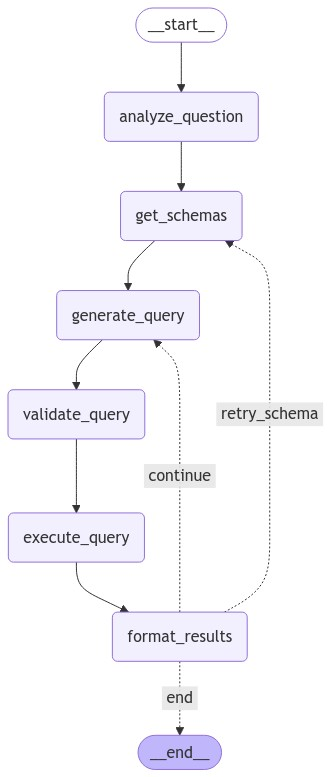

In [173]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [174]:
if __name__ == "__main__":
    # Test the agent
    questions = [
        "What are the fundamentals of apple - ticker AAPL for today?"
    ]
    
    for question in questions:
        print("\nQuestion:", question)
        print("-" * 50)
        result = query_database(question)
        print("Response:", result)
        print("=" * 80)


Question: What are the fundamentals of apple - ticker AAPL for today?
--------------------------------------------------
Response: SQL Query:
```sql
SELECT f.ticker, f.date, f.ttm_net_eps, f.pe_ratio, f.ttm_sales_per_share, f.book_value_per_share, f.ttm_fcf_per_share, f.current_assets, f.current_ratio, f.current_assets_inventory, f.quick_ratio, f.total_liabilities, f.debt_to_equity_ratio, f.return_on_equity, f.return_on_assets, f.return_on_investment, f.tangible_equity, f.return_on_tangible_equity, f.price, f.current_liabilities, f.shareholders_equity, f.ttm_net_income, f.cash_on_hand, f.total_share_holder_equity, f.revenue, f.gross_profit, f.operating_income, f.ebitda, f.net_income, f.eps_earnings_per_share_diluted, f.shares_outstanding, f.ps_ratio, f.pb_ratio, f.pfcf_ratio, f.total_assets 
FROM fundamentals f 
WHERE f.ticker = 'AAPL' AND f.date = '2022-09-30';
```

Results:
| Ticker | Date       | TTM Net EPS | P/E Ratio | TTM Sales per Share | Book Value per Share | TTM FCF per Sha

In [175]:
if __name__ == "__main__":
    # Test the agent
    questions = [
        "What are all the company stock values present in the database. provide me the unique companies (ticker) in the price table?"
    ]
    
    for question in questions:
        print("\nQuestion:", question)
        print("-" * 50)
        result = query_database(question)
        print("Response:", result)
        print("=" * 80)


Question: What are all the company stock values present in the database. provide me the unique companies (ticker) in the price table?
--------------------------------------------------
Response: SQL Query:
```sql
SELECT DISTINCT ticker FROM price;
```

Results:
- AAPL
- ABBV
- ABT
- ACN
- ADBE
- AMZN
- ASML
- AVGO
- AZN
- BABA
- BAC
- BMY
- BRK.A
- CMCSA
- COP
- COST
- CSCO
- CVX
- DHR
- DIS
- GOOGL
- HD
- JNJ
- JPM
- KO
- LIN
- LLY
- MA
- MCD
- META
- MRK
- MSFT
- NEE
- NKE
- NVDA
- NVS
- ORCL
- PEP
- PFE
- PG
- PM
- RTX
- SCHW
- SHEL
- TMO
- TMUS
- TSLA
- TTE
- TXN
- UNH
- UPS
- V
- VZ
- WFC
- WMT
- XOM


In [176]:
if __name__ == "__main__":
    # Test the agent
    questions = [
        "Which is the industry pe value for apple?"
    ]
    
    for question in questions:
        print("\nQuestion:", question)
        print("-" * 50)
        result = query_database(question)
        print("Response:", result)
        print("=" * 80)


Question: Which is the industry pe value for apple?
--------------------------------------------------
Response: SQL Query:
```sql
SELECT ipr.pe_ratio 
FROM industry_pe_ratios ipr 
JOIN industry_ticker_mapping itm ON ipr.industry = itm.industry 
WHERE itm.ticker = 'AAPL'
```

Results:
- Price-to-Earnings Ratio (P/E Ratio) for AAPL: 32.28


In [177]:
if __name__ == "__main__":
    # Test the agent
    questions = [
        "Provide me the financial information of microsoft like revenue profit and EBIDTA for today"
    ]
    
    for question in questions:
        print("\nQuestion:", question)
        print("-" * 50)
        result = query_database(question)
        print("Response:", result)
        print("=" * 80)


Question: Provide me the financial information of microsoft like revenue profit and EBIDTA for today
--------------------------------------------------
Response: SQL Query:
```sql
SELECT rp.revenue, rp.ebitda 
FROM revenue_profit rp 
WHERE rp.ticker = 'MSFT' AND rp.date = '2022-09-30'
```

Results:
- Revenue: $50,122.0
- EBITDA: $24,308.0


In [178]:
if __name__ == "__main__":
    # Test the agent
    questions = [
        "Which is the industry pe value for apple?",
        "Which is the industry pe value for microsoft?"
    ]
    
    for question in questions:
        print("\nQuestion:", question)
        print("-" * 50)
        result = query_database(question)
        print("Response:", result)
        print("=" * 80)


Question: Which is the industry pe value for apple?
--------------------------------------------------
Response: SQL Query:
```sql
SELECT ipr.pe_ratio 
FROM industry_pe_ratios ipr 
JOIN industry_ticker_mapping itm ON ipr.industry = itm.industry 
WHERE itm.ticker = 'AAPL'
```

Results:
- Price-to-Earnings Ratio (P/E Ratio) for AAPL: 32.28

Question: Which is the industry pe value for microsoft?
--------------------------------------------------
Response: SQL Query:
```sql
SELECT ipr.pe_ratio 
FROM industry_pe_ratios ipr 
JOIN industry_ticker_mapping itm ON ipr.industry = itm.industry 
WHERE itm.ticker = 'MSFT'
```

Results:
- Price-to-Earnings Ratio (P/E Ratio) for Microsoft (MSFT): **33.68**


In [180]:
for event in agent.stream(
    {"messages": [("user", "What are the fundamentals of apple - ticker AAPL for today ?")]}
):
    print(event)


{'analyze_question': {'messages': [HumanMessage(content='What are the fundamentals of apple - ticker AAPL for today ?', additional_kwargs={}, response_metadata={}, id='55f23c7f-9f5b-4aa5-b11b-bf93e56ecec1'), AIMessage(content='fundamentals, price', additional_kwargs={}, response_metadata={}, id='7dcad1b9-e7a5-495a-a1f1-be44dcaaf9f5')]}}
{'get_schemas': {'messages': [HumanMessage(content='What are the fundamentals of apple - ticker AAPL for today ?', additional_kwargs={}, response_metadata={}, id='55f23c7f-9f5b-4aa5-b11b-bf93e56ecec1'), AIMessage(content='fundamentals, price', additional_kwargs={}, response_metadata={}, id='7dcad1b9-e7a5-495a-a1f1-be44dcaaf9f5'), AIMessage(content='\nCREATE TABLE fundamentals (\n\tticker TEXT, \n\tdate TEXT, \n\tttm_net_eps REAL, \n\tpe_ratio REAL, \n\tttm_sales_per_share REAL, \n\tbook_value_per_share REAL, \n\tttm_fcf_per_share REAL, \n\tcurrent_assets REAL, \n\tcurrent_ratio REAL, \n\tcurrent_assets_inventory REAL, \n\tquick_ratio REAL, \n\ttotal_lia

In [181]:
for event in agent.stream(
    {"messages": [("user", "What are all the company stock values present in the database. provide me the unique companies (ticker) in the price table?")]}
):
    print(event)


{'analyze_question': {'messages': [HumanMessage(content='What are all the company stock values present in the database. provide me the unique companies (ticker) in the price table?', additional_kwargs={}, response_metadata={}, id='4953f64a-deaf-40de-bc92-18812dfc6530'), AIMessage(content='price', additional_kwargs={}, response_metadata={}, id='579a1969-f09c-445b-8a56-fed0a15c3ce3')]}}
{'get_schemas': {'messages': [HumanMessage(content='What are all the company stock values present in the database. provide me the unique companies (ticker) in the price table?', additional_kwargs={}, response_metadata={}, id='4953f64a-deaf-40de-bc92-18812dfc6530'), AIMessage(content='price', additional_kwargs={}, response_metadata={}, id='579a1969-f09c-445b-8a56-fed0a15c3ce3'), AIMessage(content='\nCREATE TABLE price (\n\tticker TEXT, \n\tdate TEXT, \n\topen REAL, \n\thigh REAL, \n\tlow REAL, \n\tclose REAL, \n\tvolume INTEGER, \n\tdividends REAL, \n\tstock_splits REAL\n)\n\n/*\n3 rows from price table:\n

In [182]:
for event in agent.stream(
        {"messages": [("user", "Which is the industry pe value for microsoft?")]}
    ):
    print(event)


{'analyze_question': {'messages': [HumanMessage(content='Which is the industry pe value for microsoft?', additional_kwargs={}, response_metadata={}, id='e05194df-8c44-4288-95b7-a9a78104a888'), AIMessage(content='industry_pe_ratios, industry_ticker_mapping', additional_kwargs={}, response_metadata={}, id='61a9cbcc-f40a-4759-bd1e-743ff61db75d')]}}
{'get_schemas': {'messages': [HumanMessage(content='Which is the industry pe value for microsoft?', additional_kwargs={}, response_metadata={}, id='e05194df-8c44-4288-95b7-a9a78104a888'), AIMessage(content='industry_pe_ratios, industry_ticker_mapping', additional_kwargs={}, response_metadata={}, id='61a9cbcc-f40a-4759-bd1e-743ff61db75d'), AIMessage(content='\nCREATE TABLE industry_pe_ratios (\n\tindustry TEXT, \n\tpe_ratio REAL, \n\tnumber_of_companies INTEGER\n)\n\n/*\n3 rows from industry_pe_ratios table:\nindustry\tpe_ratio\tnumber_of_companies\nAdvertising Agencies\t15.21\t23\nAerospace & Defense\t26.95\t50\nAgricultural Inputs\t22.83\t11\n

In [184]:
import requests
def get_stock_price(symbol):
    """
    Fetch the current stock price for the given symbol, the current volume, the average price 50d and 200d, EPS, PE and the next earnings Announcement.
    """
    url = f"https://financialmodelingprep.com/api/v3/quote-order/{symbol}?apikey={FINANCIAL_MODELING_PREP_API_KEY}"
    response = requests.get(url)
    data = response.json()
    try:
        price = data[0]['price']
        volume = data[0]['volume']
        priceAvg50 = data[0]['priceAvg50']
        priceAvg200 = data[0]['priceAvg200']
        eps = data[0]['eps']
        pe = data[0]['pe']
        earningsAnnouncement = data[0]['earningsAnnouncement']
        return {"symbol": symbol.upper(), "price": price, "volume":volume,"priceAvg50":priceAvg50, "priceAvg200":priceAvg200, "EPS":eps, "PE":pe, "earningsAnnouncement":earningsAnnouncement }
    except (IndexError, KeyError):
        return {"error": f"Could not fetch price for symbol: {symbol}"}


In [185]:
def get_company_financials(symbol):
    """
    Fetch basic financial information for the given company symbol such as the industry, the sector, the name of the company, and the market capitalization.
    """
    url = f"https://financialmodelingprep.com/api/v3/profile/{symbol}?apikey={FINANCIAL_MODELING_PREP_API_KEY}"
    response = requests.get(url)
    data = response.json()
    try:
        results = data[0]
        financials = {
            "symbol": results["symbol"],
            "companyName": results["companyName"],
            "marketCap": results["mktCap"],
            "industry": results["industry"],
            "sector": results["sector"],
            "website": results["website"],
            "beta":results["beta"],
            "price":results["price"],
        }
        return financials
    except (IndexError, KeyError):
        return {"error": f"Could not fetch financials for symbol: {symbol}"}


In [186]:
def get_income_statement(symbol):
    """
    Fetch last income statement for the given company symbol such as revenue, gross profit, net income, EBITDA, EPS.
    """
    url = f"https://financialmodelingprep.com/api/v3/income-statement/{symbol}?period=annual&apikey={FINANCIAL_MODELING_PREP_API_KEY}"
    response = requests.get(url)
    data = response.json()
    try:
        results = data[0]
        financials = {
            "date": results["date"],
            "revenue": results["revenue"],
            "gross profit": results["grossProfit"],
            "net Income": results["netIncome"],
            "ebitda": results["ebitda"],
            "EPS": results["eps"],
            "EPS diluted":results["epsdiluted"]
        }
        return data, financials
    except (IndexError, KeyError):
        return {"error": f"Could not fetch financials for symbol: {symbol}"}

In [189]:
def get_balance_sheet(symbol):
    """
    Fetch balance sheet statement for the given company symbol.
    Returns both full data and key metrics from the most recent balance sheet.
    """
    url = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{symbol}?period=annual&apikey={FINANCIAL_MODELING_PREP_API_KEY}"
    
    try:
        response = requests.get(url)
        data = response.json()
        
        # Get most recent statement
        latest = data[0]
        
        # Extract key metrics
        financials = {
            "date": latest["date"],
            "filing_date": latest["fillingDate"],
            "period": latest["period"],
            
            # Assets
            "cash_and_equivalents": latest["cashAndCashEquivalents"],
            "short_term_investments": latest["shortTermInvestments"],
            "cash_and_short_term_investments": latest["cashAndShortTermInvestments"],
            "net_receivables": latest["netReceivables"],
            "inventory": latest["inventory"],
            "total_current_assets": latest["totalCurrentAssets"],
            "total_non_current_assets": latest["totalNonCurrentAssets"],
            "total_assets": latest["totalAssets"],
            
            # Liabilities
            "accounts_payable": latest["accountPayables"],
            "short_term_debt": latest["shortTermDebt"],
            "total_current_liabilities": latest["totalCurrentLiabilities"],
            "long_term_debt": latest["longTermDebt"],
            "total_non_current_liabilities": latest["totalNonCurrentLiabilities"],
            "total_liabilities": latest["totalLiabilities"],
            
            # Equity
            "retained_earnings": latest["retainedEarnings"],
            "total_stockholders_equity": latest["totalStockholdersEquity"],
            
            # Key Metrics
            "total_debt": latest["totalDebt"],
            "net_debt": latest["netDebt"],
            
            # Ratios (calculated)
            "current_ratio": round(latest["totalCurrentAssets"] / latest["totalCurrentLiabilities"], 2),
            "debt_to_equity": round(latest["totalDebt"] / latest["totalStockholdersEquity"], 2) if latest["totalStockholdersEquity"] != 0 else None
        }
        
        return data, financials
    
    except Exception as e:
        return {"error": f"Could not fetch balance sheet for {symbol}. Error: {str(e)}"}

In [194]:
def get_cash_flow(symbol):
    """
    Fetch cash flow statement for the given company symbol.
    Returns both full data and key metrics from the most recent cash flow statement.
    """
    url = f"https://financialmodelingprep.com/api/v3/cash-flow-statement/{symbol}?period=annual&apikey={FINANCIAL_MODELING_PREP_API_KEY}"
    
    try:
        response = requests.get(url)
        data = response.json()
        
        # Get most recent statement
        latest = data[0]
        
        # Extract key metrics
        financials = {
            "date": latest["date"],
            "filing_date": latest["fillingDate"],
            "period": latest["period"],
            
            # Operating Activities
            "net_income": latest["netIncome"],
            "depreciation_amortization": latest["depreciationAndAmortization"],
            "stock_based_compensation": latest["stockBasedCompensation"],
            "working_capital_changes": latest["changeInWorkingCapital"],
            "operating_cash_flow": latest["netCashProvidedByOperatingActivities"],
            
            # Working Capital Components
            "accounts_receivable_change": latest["accountsReceivables"],
            "inventory_change": latest["inventory"],
            "accounts_payable_change": latest["accountsPayables"],
            
            # Investing Activities
            "capex": latest["investmentsInPropertyPlantAndEquipment"],
            "acquisitions": latest["acquisitionsNet"],
            "investment_purchases": latest["purchasesOfInvestments"],
            "investment_sales": latest["salesMaturitiesOfInvestments"],
            "investing_cash_flow": latest["netCashUsedForInvestingActivites"],
            
            # Financing Activities
            "debt_repayment": latest["debtRepayment"],
            "stock_repurchased": latest["commonStockRepurchased"],
            "dividends_paid": latest["dividendsPaid"],
            "financing_cash_flow": latest["netCashUsedProvidedByFinancingActivities"],
            
            # Cash Position
            "net_change_in_cash": latest["netChangeInCash"],
            "cash_end_period": latest["cashAtEndOfPeriod"],
            "cash_beginning_period": latest["cashAtBeginningOfPeriod"],
            
            # Key Metrics
            "free_cash_flow": latest["freeCashFlow"],
            "fcf_margin": round((latest["freeCashFlow"] / latest["netIncome"]) * 100, 2) if latest["netIncome"] != 0 else None
        }
        
        return data, financials
    
    except Exception as e:
        return {"error": f"Could not fetch cash flow statement for {symbol}. Error: {str(e)}"}

In [188]:
print(get_stock_price("AAPL"))
print("-"*50)
print(get_company_financials("AAPL"))
print("-"*50)
print(get_income_statement("AAPL"))


{'symbol': 'AAPL', 'price': 222.435, 'volume': 24294294, 'priceAvg50': 227.1338, 'priceAvg200': 202.15245, 'EPS': 6.09, 'PE': 36.52, 'earningsAnnouncement': '2025-01-30T21:00:00.000+0000'}
--------------------------------------------------
{'symbol': 'AAPL', 'companyName': 'Apple Inc.', 'marketCap': 3381923983500, 'industry': 'Consumer Electronics', 'sector': 'Technology', 'website': 'https://www.apple.com', 'beta': 1.239, 'price': 222.435}
--------------------------------------------------
([{'date': '2024-09-28', 'symbol': 'AAPL', 'reportedCurrency': 'USD', 'cik': '0000320193', 'fillingDate': '2024-11-01', 'acceptedDate': '2024-11-01 06:01:36', 'calendarYear': '2024', 'period': 'FY', 'revenue': 391035000000, 'costOfRevenue': 210352000000, 'grossProfit': 180683000000, 'grossProfitRatio': 0.4620634982, 'researchAndDevelopmentExpenses': 31370000000, 'generalAndAdministrativeExpenses': 0, 'sellingAndMarketingExpenses': 0, 'sellingGeneralAndAdministrativeExpenses': 26097000000, 'otherExpe

In [193]:
get_balance_sheet("MSFT")


([{'date': '2024-06-30',
   'symbol': 'MSFT',
   'reportedCurrency': 'USD',
   'cik': '0000789019',
   'fillingDate': '2024-07-30',
   'acceptedDate': '2024-07-30 16:06:22',
   'calendarYear': '2024',
   'period': 'FY',
   'cashAndCashEquivalents': 18315000000,
   'shortTermInvestments': 57228000000,
   'cashAndShortTermInvestments': 75543000000,
   'netReceivables': 56924000000,
   'inventory': 1246000000,
   'otherCurrentAssets': 26021000000,
   'totalCurrentAssets': 159734000000,
   'propertyPlantEquipmentNet': 154552000000,
   'goodwill': 119220000000,
   'intangibleAssets': 27597000000,
   'goodwillAndIntangibleAssets': 146817000000,
   'longTermInvestments': 19519000000,
   'taxAssets': 22270000000,
   'otherNonCurrentAssets': 9271000000,
   'totalNonCurrentAssets': 352429000000,
   'otherAssets': 0,
   'totalAssets': 512163000000,
   'accountPayables': 21996000000,
   'shortTermDebt': 8942000000,
   'taxPayables': 5017000000,
   'deferredRevenue': 57582000000,
   'otherCurrentLi

In [195]:
get_cash_flow("MSFT")

([{'date': '2024-06-30',
   'symbol': 'MSFT',
   'reportedCurrency': 'USD',
   'cik': '0000789019',
   'fillingDate': '2024-07-30',
   'acceptedDate': '2024-07-30 16:06:22',
   'calendarYear': '2024',
   'period': 'FY',
   'netIncome': 88136000000,
   'depreciationAndAmortization': 22287000000,
   'deferredIncomeTax': -4738000000,
   'stockBasedCompensation': 10734000000,
   'changeInWorkingCapital': 1824000000,
   'accountsReceivables': -7191000000,
   'inventory': 1284000000,
   'accountsPayables': 3545000000,
   'otherWorkingCapital': 4186000000,
   'otherNonCashItems': 57975000000,
   'netCashProvidedByOperatingActivities': 118548000000,
   'investmentsInPropertyPlantAndEquipment': -44477000000,
   'acquisitionsNet': -69132000000,
   'purchasesOfInvestments': -17732000000,
   'salesMaturitiesOfInvestments': 35669000000,
   'otherInvestingActivites': -1298000000,
   'netCashUsedForInvestingActivites': -96970000000,
   'debtRepayment': -575000000,
   'commonStockIssued': 2002000000,


In [25]:
from langchain_community.agent_toolkits.polygon.toolkit import PolygonToolkit
from langchain_community.utilities.polygon import PolygonAPIWrapper

polygon = PolygonAPIWrapper()
ptoolkit = PolygonToolkit.from_polygon_api_wrapper(polygon)

In [26]:
tools = ptoolkit.get_tools()
print(tools)
for tool in tools:
    print(tool.name)
polygon_agg_tool = next(tool for tool in tools if tool.name == "polygon_aggregates")

polygon_last_quote_tool = next(tool for tool in tools if tool.name == "polygon_last_quote")
polygon_ticker_news_tool = next(tool for tool in tools if tool.name == "polygon_ticker_news")
polygon_financials_tool = next(tool for tool in tools if tool.name == "polygon_financials")


[PolygonAggregates(api_wrapper=PolygonAPIWrapper(polygon_api_key='vCqOjyxEBZuXZmMHEiZJ6QAEKUyIhBCY')), PolygonLastQuote(api_wrapper=PolygonAPIWrapper(polygon_api_key='vCqOjyxEBZuXZmMHEiZJ6QAEKUyIhBCY')), PolygonTickerNews(api_wrapper=PolygonAPIWrapper(polygon_api_key='vCqOjyxEBZuXZmMHEiZJ6QAEKUyIhBCY')), PolygonFinancials(api_wrapper=PolygonAPIWrapper(polygon_api_key='vCqOjyxEBZuXZmMHEiZJ6QAEKUyIhBCY'))]
polygon_aggregates
polygon_last_quote
polygon_ticker_news
polygon_financials


In [7]:
# polygon_last_quote_tool

In [28]:
# For aggregates tool
aggregate_result = polygon_agg_tool.invoke({
    'ticker': 'AAPL', 
    'timespan': 'day', 
    'timespan_multiplier': 1, 
    'from_date': '2023-10-05', 
    'to_date': '2024-10-05'
})

aggregate_result

'[{"v": 48527918.0, "vw": 174.2297, "o": 173.79, "c": 174.91, "h": 175.45, "l": 172.68, "t": 1696478400000, "n": 509175}, {"v": 57266675.0, "vw": 176.3366, "o": 173.8, "c": 177.49, "h": 177.99, "l": 173.18, "t": 1696564800000, "n": 593944}, {"v": 42344772.0, "vw": 177.8683, "o": 176.81, "c": 178.99, "h": 179.05, "l": 175.8, "t": 1696824000000, "n": 518256}, {"v": 43698019.0, "vw": 178.6901, "o": 178.1, "c": 178.39, "h": 179.72, "l": 177.95, "t": 1696910400000, "n": 524939}, {"v": 47544848.0, "vw": 178.9503, "o": 178.2, "c": 179.8, "h": 179.85, "l": 177.6, "t": 1696996800000, "n": 503477}, {"v": 56743119.0, "vw": 180.9482, "o": 180.07, "c": 180.71, "h": 182.34, "l": 179.04, "t": 1697083200000, "n": 616891}, {"v": 51412082.0, "vw": 179.4154, "o": 181.42, "c": 178.85, "h": 181.93, "l": 178.14, "t": 1697169600000, "n": 531441}, {"v": 52516984.0, "vw": 178.1478, "o": 176.75, "c": 178.72, "h": 179.075, "l": 176.51, "t": 1697428800000, "n": 632605}, {"v": 57549350.0, "vw": 176.8623, "o": 176.

In [224]:
# polygon_last_quote_tool.invoke({"query": "AAPL"})


In [221]:
# For news tool
news_result = polygon_ticker_news_tool.invoke({"query": "MSFT"})


news_result

'[{"id": "9fd1318c1107788da330c702578ace8f4e563595be7e219b4562be51829d0112", "publisher": {"name": "Investing.com", "homepage_url": "https://www.investing.com/", "logo_url": "https://s3.polygon.io/public/assets/news/logos/investing.png", "favicon_url": "https://s3.polygon.io/public/assets/news/favicons/investing.ico"}, "title": "What Happens Next for the Market Is in Nvidia\\u2019s Hands", "author": "Michael Kramer", "published_utc": "2024-11-05T06:46:00Z", "article_url": "https://www.investing.com/analysis/what-happens-next-for-the-market-is-in-nvidias-hands-200653756", "tickers": ["NVDA", "META", "AMZN", "AAPL", "AVGO", "MSFT"], "amp_url": "https://m.investing.com/analysis/what-happens-next-for-the-market-is-in-nvidias-hands-200653756?ampMode=1", "image_url": "https://i-invdn-com.investing.com/redesign/images/seo/investingcom_analysis_og.jpg", "description": "The market\'s direction between now and year-end will likely depend on Nvidia\'s performance, as the company accounts for a si

In [223]:

# For financials tool
financials_result = polygon_financials_tool.invoke({"query": "AAPL"})

financials_result

'[{"start_date": "2023-10-01", "end_date": "2024-09-28", "filing_date": "2024-11-01", "acceptance_datetime": "2024-11-01T10:01:36Z", "timeframe": "ttm", "fiscal_period": "TTM", "fiscal_year": "2024", "cik": "0000320193", "sic": "3571", "tickers": ["AAPL"], "company_name": "Apple Inc.", "source_filing_url": "https://api.polygon.io/v1/reference/sec/filings/0000320193-24-000123", "source_filing_file_url": "http://api.polygon.io/v1/reference/sec/filings/0000320193-24-000123/files/aapl-20240928_htm.xml", "financials": {"cash_flow_statement": {"net_cash_flow_from_investing_activities": {"value": 2935000000.0, "unit": "USD", "label": "Net Cash Flow From Investing Activities", "order": 400}, "net_cash_flow_from_investing_activities_continuing": {"value": 2935000000.0, "unit": "USD", "label": "Net Cash Flow From Investing Activities, Continuing", "order": 500}, "net_cash_flow_from_financing_activities": {"value": -121983000000.0, "unit": "USD", "label": "Net Cash Flow From Financing Activities"

In [9]:
@tool
def company_news(company_name: str) -> list:
    """
    Searches for a collection of news articles [most relevant, most socially shared and keyword based news] based on the given company name and industry keywords, and returns the news context as a list of articles.

    Args:
        company_name (str): The name of the company for finding relevant news articles.
        industry_keywords (list): A list of keywords related to the industry.

    Returns:
        list: A list of dictionaries containing the news articles.
    """
    news = []

    # Get most relevant news articles based on the company name
    q_pos = QueryArticlesIter(
        conceptUri=er.getConceptUri(company_name),
        categoryUri=er.getCategoryUri("investing"),
        dataType=["news"],
        lang="eng"
    )
    for art in q_pos.execQuery(er, sortBy="cosSim", maxItems=10):
        news.append(art)
    return news

@tool
def industry_news(industry_keywords: list) -> list:
    """
    Fetches the most relevant articles related to a given list of industry keywords.
    Args:
        industry_keywords (list): A list of keywords representing the industry of interest.
    Returns:
        list: A list of news articles related to the provided industry keywords.

    """
    news = []

    q_pos = QueryArticlesIter(
        conceptUri=QueryItems.OR([er.getConceptUri(i) for i in industry_keywords]),
        categoryUri=er.getCategoryUri("investing"),
        dataType=["news"],
        lang = "eng"
    )
    for art in q_pos.execQuery(er, sortBy="cosSim", maxItems=10): #sort by options - 
        news.append(art)

    return news



In [10]:
company_name = "Apple inc."
keywords = ["computers", "electronics"]

# Use the invoke method instead of __call__
response = industry_news.invoke({"industry_keywords": keywords})
response

[{'uri': '2024-11-537547781',
  'lang': 'eng',
  'isDuplicate': False,
  'date': '2024-11-06',
  'time': '11:25:44',
  'dateTime': '2024-11-06T11:25:44Z',
  'dateTimePub': '2024-11-06T11:25:30Z',
  'dataType': 'news',
  'sim': 0.9843137264251709,
  'url': 'https://www.itnewsonline.com/BusinessWire/PayPay-and-AlipayNo.43-Extend-Enhanced-E-Wallet-Payment-Options-to-Over-3-Million-Merchants-Across-Japan-With-Expanded-Partnership/34191',
  'title': 'PayPay and Alipay+ Extend Enhanced E-Wallet Payment Options to Over 3 Million Merchants Across Japan With Expanded Partnership',
  'body': 'At the Singapore FinTech Festival 2024, PayPay, Japan\'s top QR payment operator, today announced an expanded partnership with Alipay+, Ant International\'s cross-border mobile payment and digitalisation technology solution, broadening its merchant coverage network across Japan. By working with local partners including PayPay, Alipay+ will now connect over 3 million local merchants to the global payment eco

In [3]:
apha_api_key="T5WFNAVFRWA4BJ2B"
def get_news_sentiment(symbol: str) -> dict:
    """
    Fetch news sentiment for a given stock symbol using Alpha Vantage API.
    
    Args:
        symbol (str): Stock ticker symbol (e.g., 'AAPL')
        
    Returns:
        dict: News sentiment data including feed entries and metadata
    """
    try:
        url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={symbol}&apikey={apha_api_key}'
        response = requests.get(url)
        data = response.json()
        
        if "Error Message" in data:
            return {"error": data["Error Message"]}
            
        return data
    except Exception as e:
        return {"error": f"Failed to fetch news sentiment: {str(e)}"}

def get_insider_transactions(symbol: str) -> dict:
    """
    Fetch insider transactions for a given stock symbol using Alpha Vantage API.
    
    Args:
        symbol (str): Stock ticker symbol (e.g., 'IBM')
        
    Returns:
        dict: Insider transactions data including recent transactions and metadata
    """
    try:
        url = f'https://www.alphavantage.co/query?function=INSIDER_TRANSACTIONS&symbol={symbol}&apikey={apha_api_key}'
        response = requests.get(url)
        data = response.json()
        
        if "Error Message" in data:
            return {"error": data["Error Message"]}
            
        return data
    except Exception as e:
        return {"error": f"Failed to fetch insider transactions: {str(e)}"}

# Example usage:
if __name__ == "__main__":
    # Test news sentiment
    apple_news = get_news_sentiment("AAPL")
    print("News Sentiment for AAPL:")
    print("-" * 50)
    print(apple_news)
    print("\n")
    
    # Test insider transactions
    ibm_insider = get_insider_transactions("NVDA")
    print("Insider Transactions for IBM:")
    print("-" * 50)
    print(ibm_insider)

News Sentiment for AAPL:
--------------------------------------------------
{'error': "Failed to fetch news sentiment: name 'requests' is not defined"}


Insider Transactions for IBM:
--------------------------------------------------
{'error': "Failed to fetch insider transactions: name 'requests' is not defined"}


In [4]:
def get_news_sentiment(symbol: str) -> dict:
    """
    Fetch and summarize news sentiment with relevant articles for a given stock symbol.
    
    Args:
        symbol (str): Stock ticker symbol (e.g., 'AAPL')
        
    Returns:
        dict: Summarized news sentiment data including:
            - overall_sentiment: Average sentiment across all articles
            - sentiment_distribution: Count of articles by sentiment category
            - top_tickers: Most frequently mentioned related tickers
            - key_topics: Most relevant topics from the news
            - relevant_news: List of relevant news articles with title and summary
    """
    try:
        url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={symbol}&apikey={apha_api_key}'
        response = requests.get(url)
        data = response.json()
        
        if "Error Message" in data:
            return {"error": data["Error Message"]}
            
        # Initialize counters
        sentiment_counts = {
            "Bearish": 0,
            "Somewhat-Bearish": 0,
            "Neutral": 0,
            "Somewhat-Bullish": 0,
            "Bullish": 0
        }
        
        ticker_mentions = {}
        topics = {}
        total_sentiment = 0
        article_count = 0
        relevant_news = []
        
        # Process each article
        for article in data.get('feed', []):
            # Check if article is relevant to the requested symbol
            is_relevant = False
            for ticker_data in article.get('ticker_sentiment', []):
                if ticker_data['ticker'] == symbol and float(ticker_data['relevance_score']) > 0.5:
                    is_relevant = True
                    break
            
            # Store relevant news
            if is_relevant:
                relevant_news.append({
                    'title': article['title'],
                    'summary': article['summary'],
                    'time_published': article['time_published'],
                    'sentiment_score': article['overall_sentiment_score'],
                    'sentiment_label': article['overall_sentiment_label']
                })
            
            # Count sentiment labels
            sentiment_counts[article['overall_sentiment_label']] += 1
            total_sentiment += article['overall_sentiment_score']
            article_count += 1
            
            # Count ticker mentions
            for ticker_data in article.get('ticker_sentiment', []):
                ticker = ticker_data['ticker']
                ticker_mentions[ticker] = ticker_mentions.get(ticker, 0) + 1
            
            # Count topic mentions
            for topic_data in article.get('topics', []):
                topic = topic_data['topic']
                relevance = float(topic_data['relevance_score'])
                topics[topic] = topics.get(topic, 0) + relevance

        # Prepare summary
        summary = {
            "overall_sentiment": round(total_sentiment / max(1, article_count), 3),
            "sentiment_distribution": sentiment_counts,
            "top_tickers": dict(sorted(ticker_mentions.items(), key=lambda x: x[1], reverse=True)[:5]),
            "key_topics": dict(sorted(topics.items(), key=lambda x: x[1], reverse=True)[:5]),
            "relevant_news": sorted(relevant_news, 
                                  key=lambda x: x['time_published'], 
                                  reverse=True)[:5]  # Get 5 most recent relevant articles
        }
            
        return summary
    except Exception as e:
        return {"error": f"Failed to fetch news sentiment: {str(e)}"}


# Example usage:
if __name__ == "__main__":
    # Test news sentiment
    apple_news = get_news_sentiment("NVDA")
    print("News Sentiment for AAPL:")
    print("-" * 50)
    print(apple_news)
    print("\n")
    

News Sentiment for AAPL:
--------------------------------------------------
{'error': "Failed to fetch news sentiment: name 'requests' is not defined"}




In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Use your existing Alpha Vantage API key
ALPHA_VANTAGE_API_KEY = apha_api_key  # From your existing code

@tool
def get_technical_indicators(symbol: str) -> dict:
    """
    Calculate technical indicators using Alpha Vantage Technical Indicators API
    """
    try:
        indicators = {}
        base_url = "https://www.alphavantage.co/query"
        
        # Get RSI
        rsi_params = {
            "function": "RSI",
            "symbol": symbol,
            "interval": "daily",
            "time_period": 14,
            "series_type": "close",
            "apikey": ALPHA_VANTAGE_API_KEY
        }
        rsi_response = requests.get(base_url, params=rsi_params)
        rsi_data = rsi_response.json()
        
        # Get MACD
        macd_params = {
            "function": "MACD",
            "symbol": symbol,
            "interval": "daily",
            "series_type": "close",
            "apikey": ALPHA_VANTAGE_API_KEY
        }
        macd_response = requests.get(base_url, params=macd_params)
        macd_data = macd_response.json()
        
        # Get Bollinger Bands
        bbands_params = {
            "function": "BBANDS",
            "symbol": symbol,
            "interval": "daily",
            "time_period": 20,
            "series_type": "close",
            "apikey": ALPHA_VANTAGE_API_KEY
        }
        bbands_response = requests.get(base_url, params=bbands_params)
        bbands_data = bbands_response.json()
        
        # Get Stochastic Oscillator
        stoch_params = {
            "function": "STOCH",
            "symbol": symbol,
            "interval": "daily",
            "apikey": ALPHA_VANTAGE_API_KEY
        }
        stoch_response = requests.get(base_url, params=stoch_params)
        stoch_data = stoch_response.json()
        
        # Extract most recent values
        latest_date = list(rsi_data.get("Technical Analysis: RSI", {}).keys())[0]
        
        indicators = {
            "date": latest_date,
            "rsi": float(rsi_data["Technical Analysis: RSI"][latest_date]["RSI"]),
            "macd": {
                "macd_line": float(macd_data["Technical Analysis: MACD"][latest_date]["MACD"]),
                "signal_line": float(macd_data["Technical Analysis: MACD"][latest_date]["MACD_Signal"]),
                "histogram": float(macd_data["Technical Analysis: MACD"][latest_date]["MACD_Hist"])
            },
            "bollinger_bands": {
                "upper": float(bbands_data["Technical Analysis: BBANDS"][latest_date]["Real Upper Band"]),
                "middle": float(bbands_data["Technical Analysis: BBANDS"][latest_date]["Real Middle Band"]),
                "lower": float(bbands_data["Technical Analysis: BBANDS"][latest_date]["Real Lower Band"])
            },
            "stochastic": {
                "slow_k": float(stoch_data["Technical Analysis: STOCH"][latest_date]["SlowK"]),
                "slow_d": float(stoch_data["Technical Analysis: STOCH"][latest_date]["SlowD"])
            }
        }
        
        return indicators
    except Exception as e:
        return {"error": f"Failed to calculate technical indicators: {str(e)}"}

@tool
def get_global_market_status() -> dict:
    """
    Get global market status and major indices using Alpha Vantage Global Market Status API
    """
    try:
        params = {
            "function": "MARKET_STATUS",
            "apikey": ALPHA_VANTAGE_API_KEY
        }
        response = requests.get("https://www.alphavantage.co/query", params=params)
        data = response.json()
        
        return {
            "markets": data.get("markets", []),
            "timestamp": datetime.now().isoformat()
        }
    except Exception as e:
        return {"error": f"Failed to fetch market status: {str(e)}"}

@tool
def get_economic_indicators() -> dict:
    """
    Fetch economic indicators using Alpha Vantage Economic Indicators API
    """
    try:
        indicators = {}
        base_url = "https://www.alphavantage.co/query"
        
        # Real GDP
        gdp_params = {
            "function": "REAL_GDP",
            "interval": "quarterly",
            "apikey": ALPHA_VANTAGE_API_KEY
        }
        gdp_response = requests.get(base_url, params=gdp_params)
        gdp_data = gdp_response.json()
        
        # Inflation (CPI)
        cpi_params = {
            "function": "CPI",
            "interval": "monthly",
            "apikey": ALPHA_VANTAGE_API_KEY
        }
        cpi_response = requests.get(base_url, params=cpi_params)
        cpi_data = cpi_response.json()
        
        # Unemployment Rate
        unemployment_params = {
            "function": "UNEMPLOYMENT",
            "apikey": ALPHA_VANTAGE_API_KEY
        }
        unemployment_response = requests.get(base_url, params=unemployment_params)
        unemployment_data = unemployment_response.json()
        
        # Federal Funds Rate
        fed_rate_params = {
            "function": "FEDERAL_FUNDS_RATE",
            "interval": "monthly",
            "apikey": ALPHA_VANTAGE_API_KEY
        }
        fed_rate_response = requests.get(base_url, params=fed_rate_params)
        fed_rate_data = fed_rate_response.json()
        
        # Extract most recent values
        indicators = {
            "gdp": {
                "value": float(gdp_data["data"][0]["value"]),
                "date": gdp_data["data"][0]["date"]
            },
            "inflation_rate": {
                "value": float(cpi_data["data"][0]["value"]),
                "date": cpi_data["data"][0]["date"]
            },
            "unemployment_rate": {
                "value": float(unemployment_data["data"][0]["value"]),
                "date": unemployment_data["data"][0]["date"]
            },
            "federal_funds_rate": {
                "value": float(fed_rate_data["data"][0]["value"]),
                "date": fed_rate_data["data"][0]["date"]
            }
        }
        
        return indicators
    except Exception as e:
        return {"error": f"Failed to fetch economic indicators: {str(e)}"}

@tool
def get_earnings_calendar(symbol: str = None) -> dict:
    """
    Get earnings calendar data using Alpha Vantage Earnings Calendar API
    """
    try:
        params = {
            "function": "EARNINGS_CALENDAR",
            "apikey": ALPHA_VANTAGE_API_KEY
        }
        
        if symbol:
            params["symbol"] = symbol
            
        response = requests.get("https://www.alphavantage.co/query", params=params)
        data = response.json()
        
        return {
            "earnings_calendar": data,
            "timestamp": datetime.now().isoformat()
        }
    except Exception as e:
        return {"error": f"Failed to fetch earnings calendar: {str(e)}"}

@tool
def get_ipo_calendar() -> dict:
    """
    Get IPO calendar using Alpha Vantage IPO Calendar API
    """
    try:
        params = {
            "function": "IPO_CALENDAR",
            "apikey": ALPHA_VANTAGE_API_KEY
        }
        
        response = requests.get("https://www.alphavantage.co/query", params=params)
        data = response.json()
        
        return {
            "ipo_calendar": data,
            "timestamp": datetime.now().isoformat()
        }
    except Exception as e:
        return {"error": f"Failed to fetch IPO calendar: {str(e)}"}

# Helper function to handle API rate limiting
def handle_api_call(func):
    """
    Decorator to handle API rate limiting and errors
    """
    def wrapper(*args, **kwargs):
        try:
            response = func(*args, **kwargs)
            
            # Check for API limit messages
            if isinstance(response, dict) and "Note" in response:
                return {"error": "API call frequency limit reached. Please wait and try again."}
                
            return response
        except Exception as e:
            return {"error": f"API call failed: {str(e)}"}
            
    return wrapper

# Example usage:
technical_data = get_technical_indicators("AAPL")
market_status = get_global_market_status()
economic_data = get_economic_indicators()
earnings_data = get_earnings_calendar("AAPL")
ipo_data = get_ipo_calendar()

In [11]:
def get_insider_transactions(symbol: str) -> dict:
    """
    Fetch and summarize insider transactions for a given stock symbol.
    
    Args:
        symbol (str): Stock ticker symbol (e.g., 'IBM')
        
    Returns:
        dict: Summarized insider transactions including:
            - recent_transactions: Top 10 most significant transactions
            - transaction_summary: Summary of buying/selling activity
    """
    try:
        url = f'https://www.alphavantage.co/query?function=INSIDER_TRANSACTIONS&symbol={symbol}&apikey={apha_api_key}'
        response = requests.get(url)
        data = response.json()
        
        if "Error Message" in data:
            return {"error": data["Error Message"]}
        
        # Process transactions
        transactions = []
        total_buys = 0
        total_sells = 0
        total_buy_value = 0
        total_sell_value = 0
        
        for transaction in data.get('data', []):
            # Calculate transaction value
            shares = float(transaction['shares'])
            price = float(transaction['share_price']) if transaction['share_price'] != '0.0' else 0
            value = shares * price
            
            # Track buy/sell totals
            if transaction['acquisition_or_disposal'] == 'A':
                total_buys += 1
                total_buy_value += value
            else:
                total_sells += 1
                total_sell_value += value
            
            # Store transaction with its value
            transactions.append({
                'date': transaction['transaction_date'],
                'executive': transaction['executive'],
                'title': transaction['executive_title'],
                'type': transaction['security_type'],
                'action': 'Buy' if transaction['acquisition_or_disposal'] == 'A' else 'Sell',
                'shares': shares,
                'price': price,
                'value': value
            })
        
        # Sort by transaction value and get top 10
        significant_transactions = sorted(
            [t for t in transactions if t['value'] > 0],  # Filter out zero-value transactions
            key=lambda x: x['value'], 
            reverse=True
        )[:10]
        
        summary = {
            'recent_transactions': significant_transactions,
            'transaction_summary': {
                'total_buys': total_buys,
                'total_sells': total_sells,
                'total_buy_value': round(total_buy_value, 2),
                'total_sell_value': round(total_sell_value, 2),
                'net_transaction_value': round(total_buy_value - total_sell_value, 2)
            }
        }
            
        return summary
    except Exception as e:
        return {"error": f"Failed to fetch insider transactions: {str(e)}"}


    
    # Test insider transactions
if __name__ == "__main__":
    ibm_insider = get_insider_transactions("AAPL")
    print("Insider Transactions for IBM:")
    print("-" * 50)
    print(ibm_insider)

Insider Transactions for IBM:
--------------------------------------------------
{'recent_transactions': [], 'transaction_summary': {'total_buys': 0, 'total_sells': 0, 'total_buy_value': 0, 'total_sell_value': 0, 'net_transaction_value': 0}}


In [3]:
import requests
def get_earnings_history() -> dict:
    """
    Fetch historical earnings data for a given stock symbol.
    """

    url = f'https://www.alphavantage.co/query?function=EARNINGS&symbol=AAPL&apikey=4SU8CQ2120XE62P8'
    response = requests.get(url)
    data = response.json()

    print(data)
    return data
        

In [4]:
print(get_earnings_history())

{'Information': 'Thank you for using Alpha Vantage! Our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.'}
{'Information': 'Thank you for using Alpha Vantage! Our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.'}


In [20]:
def get_technical_analysis(
    symbol: str,
    timespan: Literal["minute", "hour", "day"] = "day",
    window: int = 50
) -> dict:
    """
    Comprehensive technical analysis using Polygon data with structured output
    """
    try:
        # Get dates
        end_date = datetime.utcnow()
        start_date = end_date - timedelta(days=window)
        
        # Format dates for polygon API
        from_date = start_date.strftime("%Y-%m-%d")
        to_date = end_date.strftime("%Y-%m-%d")
        
        print("DEBUG: Fetching data from Polygon API...")
        # Get polygon data
        response = polygon_agg_tool.invoke({
            'ticker': symbol,
            'timespan': timespan,
            'timespan_multiplier': 1,
            'from_date': from_date,
            'to_date': to_date
        })
        print(f"DEBUG: Raw response type: {type(response)}")
        print(f"DEBUG: Raw response: {response}")

        # Parse the response
        if isinstance(response, str):
            print("DEBUG: Converting string response to dict...")
            data = eval(response)
        else:
            data = response
        print(f"DEBUG: Parsed data type: {type(data)}")
        print(f"DEBUG: Parsed data keys: {data.keys() if isinstance(data, dict) else 'No keys'}")
            
        # Extract candles from the results
        if isinstance(data, dict) and 'results' in data:
            print("DEBUG: Extracting candles from results...")
            candles = data['results']
        else:
            print("DEBUG: Invalid response format - missing 'results' key")
            return {"error": "Invalid response format"}

        if not candles or len(candles) == 0:
            print("DEBUG: No candles data available")
            return {"error": "No aggregate data available"}

        print(f"DEBUG: Number of candles: {len(candles)}")
        print(f"DEBUG: Sample candle: {candles[0]}")

        # Convert to DataFrame for calculations
        print("DEBUG: Converting to DataFrame...")
        df = pd.DataFrame(candles)
        print(f"DEBUG: DataFrame columns: {df.columns}")
        
        # Calculate indicators
        print("DEBUG: Calculating indicators...")
        indicators = calculate_basic_indicators(df)
        print("DEBUG: Indicators calculated successfully")
        
        # Get the latest candle
        latest = candles[-1]
        prev = candles[-2] if len(candles) > 1 else None
        
        return {
            "technical_analysis": {
                "price_action": {
                    "current_price": latest['c'],
                    "previous_close": prev['c'] if prev else None,
                    "day_high": latest['h'],
                    "day_low": latest['l'],
                    "volume": latest['v'],
                    "raw_data": candles[-10:]  # Last 10 periods
                },
                "moving_averages": {
                    "sma_20": float(indicators["sma_20"][-1]) if not pd.isna(indicators["sma_20"][-1]) else None,
                    "sma_50": float(indicators["sma_50"][-1]) if not pd.isna(indicators["sma_50"][-1]) else None,
                },
                "momentum": {
                    "rsi": float(indicators["rsi"][-1]) if not pd.isna(indicators["rsi"][-1]) else None,
                },
                "volume_analysis": {
                    "volume_sma": float(indicators["volume_sma"][-1]) if not pd.isna(indicators["volume_sma"][-1]) else None,
                }
            }
        }
        
    except Exception as e:
        print(f"DEBUG: Exception occurred: {str(e)}")
        print(f"DEBUG: Exception type: {type(e)}")
        import traceback
        print(f"DEBUG: Traceback: {traceback.format_exc()}")
        return {"error": f"Technical analysis failed: {str(e)}"}

# Test the function
print("DEBUG: Starting technical analysis test...")
result = get_technical_analysis("AAPL")
print("\nTechnical Analysis Results:")
if "error" not in result:
    analysis = result["technical_analysis"]
    print(f"\nPrice Action:")
    print(f"Current Price: ${analysis['price_action']['current_price']}")
    print(f"Previous Close: ${analysis['price_action']['previous_close']}")
    print(f"\nMoving Averages:")
    print(f"SMA 20: ${analysis['moving_averages']['sma_20']:.2f}")
    print(f"SMA 50: ${analysis['moving_averages']['sma_50']:.2f}")
    print(f"\nMomentum:")
    print(f"RSI: {analysis['momentum']['rsi']:.2f}")
else:
    print(f"Error: {result['error']}")

DEBUG: Starting technical analysis test...
DEBUG: Fetching data from Polygon API...


DEBUG: Exception occurred: API Error: {'ticker': 'AAPL', 'queryCount': 35, 'resultsCount': 35, 'adjusted': True, 'results': [{'v': 50709047.0, 'vw': 227.0625, 'o': 227.34, 'c': 226.47, 'h': 229.45, 'l': 225.81, 't': 1727064000000, 'n': 693243}, {'v': 41499749.0, 'vw': 227.2442, 'o': 228.645, 'c': 227.37, 'h': 229.35, 'l': 225.73, 't': 1727150400000, 'n': 519517}, {'v': 39976689.0, 'vw': 225.8328, 'o': 224.93, 'c': 226.37, 'h': 227.29, 'l': 224.02, 't': 1727236800000, 'n': 564547}, {'v': 34812774.0, 'vw': 227.2682, 'o': 227.3, 'c': 227.52, 'h': 228.5, 'l': 225.41, 't': 1727323200000, 'n': 433069}, {'v': 31421839.0, 'vw': 228.1557, 'o': 228.46, 'c': 227.79, 'h': 229.52, 'l': 227.3, 't': 1727409600000, 'n': 504046}, {'v': 52877673.0, 'vw': 231.9696, 'o': 230.04, 'c': 233, 'h': 233, 'l': 229.65, 't': 1727668800000, 'n': 710005}, {'v': 59761880.0, 'vw': 225.9623, 'o': 229.52, 'c': 226.21, 'h': 229.65, 'l': 223.74, 't': 1727755200000, 'n': 832034}, {'v': 31929459.0, 'vw': 226.0301, 'o': 225.

In [22]:
print(get_technical_analysis("AAPL"))

{'error': "Technical analysis failed: No module named 'talib'"}


In [21]:

def get_technical_analysis(
    symbol: str,
    timespan: Literal["minute", "hour", "day"] = "day",
    window: int = 50
) -> dict:
    """
    Comprehensive technical analysis using Polygon data with structured output
    """
    try:
        # Get dates
        end_date = datetime.utcnow()
        start_date = end_date - timedelta(days=window)
        
        # Format dates for polygon API
        from_date = start_date.strftime("%Y-%m-%d")
        to_date = end_date.strftime("%Y-%m-%d")
        
        try:
            # Get polygon data
            response = polygon_agg_tool.invoke({
                'ticker': symbol,
                'timespan': timespan,
                'timespan_multiplier': 1,
                'from_date': from_date,
                'to_date': to_date
            })
        except ValueError as e:
            # Extract the actual response data from the error message
            error_str = str(e)
            if "API Error: " in error_str:
                response = eval(error_str.split("API Error: ", 1)[1])
            else:
                raise e

        # Extract candles from the results
        if isinstance(response, dict) and 'results' in response:
            candles = response['results']
        else:
            return {"error": "Invalid response format"}

        if not candles or len(candles) == 0:
            return {"error": "No aggregate data available"}

        # Convert to DataFrame for calculations
        df = pd.DataFrame(candles)
        
        # Calculate indicators
        indicators = calculate_basic_indicators(df)
        
        # Get the latest candle
        latest = candles[-1]
        prev = candles[-2] if len(candles) > 1 else None
        
        return {
            "technical_analysis": {
                "price_action": {
                    "current_price": latest['c'],
                    "previous_close": prev['c'] if prev else None,
                    "day_high": latest['h'],
                    "day_low": latest['l'],
                    "volume": latest['v'],
                    "raw_data": candles[-10:]  # Last 10 periods
                },
                "moving_averages": {
                    "sma_20": float(indicators["sma_20"][-1]) if not pd.isna(indicators["sma_20"][-1]) else None,
                    "sma_50": float(indicators["sma_50"][-1]) if not pd.isna(indicators["sma_50"][-1]) else None,
                },
                "momentum": {
                    "rsi": float(indicators["rsi"][-1]) if not pd.isna(indicators["rsi"][-1]) else None,
                },
                "volume_analysis": {
                    "volume_sma": float(indicators["volume_sma"][-1]) if not pd.isna(indicators["volume_sma"][-1]) else None,
                }
            }
        }
        
    except Exception as e:
        return {"error": f"Technical analysis failed: {str(e)}"}

In [24]:
from datetime import datetime, timedelta
from typing import Literal
import pandas as pd
import numpy as np

def calculate_basic_indicators(df: pd.DataFrame) -> dict:
    """Calculate basic technical indicators using pandas"""
    try:
        # Convert price and volume columns to float
        closes = df['c'].astype(float)
        volumes = df['v'].astype(float)
        
        # Calculate SMAs
        sma_20 = closes.rolling(window=20).mean()
        sma_50 = closes.rolling(window=50).mean()
        
        # Calculate RSI with error handling
        delta = closes.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        
        # Avoid division by zero in RSI calculation
        rs = gain / loss.replace(0, np.nan)
        rsi = 100 - (100 / (1 + rs))
        
        # If RSI calculation fails, set it to 50 (neutral)
        rsi = rsi.fillna(50)
        
        # Calculate Volume SMA
        volume_sma = volumes.rolling(window=20).mean()
        
        print(f"DEBUG: Indicators calculated successfully")
        print(f"DEBUG: Last SMA20: {sma_20.iloc[-1]}")
        print(f"DEBUG: Last SMA50: {sma_50.iloc[-1]}")
        print(f"DEBUG: Last RSI: {rsi.iloc[-1]}")
        print(f"DEBUG: Last Volume SMA: {volume_sma.iloc[-1]}")
        
        return {
            "sma_20": sma_20,
            "sma_50": sma_50,
            "rsi": rsi,
            "volume_sma": volume_sma,
        }
    except Exception as e:
        print(f"DEBUG: Error in calculate_basic_indicators: {str(e)}")
        # Return default values in case of error
        return {
            "sma_20": pd.Series([np.nan] * len(df)),
            "sma_50": pd.Series([np.nan] * len(df)),
            "rsi": pd.Series([50.0] * len(df)),  # Neutral RSI
            "volume_sma": pd.Series([np.nan] * len(df))
        }
def get_technical_analysis(
    symbol: str,
    timespan: Literal["minute", "hour", "day"] = "day",
    window: int = 50
) -> dict:
    """
    Comprehensive technical analysis using Polygon data with structured output
    """
    try:
        # Get dates
        end_date = datetime.utcnow()
        start_date = end_date - timedelta(days=window)
        
        # Format dates for polygon API
        from_date = start_date.strftime("%Y-%m-%d")
        to_date = end_date.strftime("%Y-%m-%d")
        
        try:
            # Get polygon data
            response = polygon_agg_tool.invoke({
                'ticker': symbol,
                'timespan': timespan,
                'timespan_multiplier': 1,
                'from_date': from_date,
                'to_date': to_date
            })
        except ValueError as e:
            # Extract the actual response data from the error message
            error_str = str(e)
            if "API Error: " in error_str:
                response = eval(error_str.split("API Error: ", 1)[1])
            else:
                raise e

        # Extract candles from the results
        if isinstance(response, dict) and 'results' in response:
            candles = response['results']
        else:
            return {"error": "Invalid response format"}

        if not candles or len(candles) == 0:
            return {"error": "No aggregate data available"}

        # Convert to DataFrame for calculations
        df = pd.DataFrame(candles)
        
        # Calculate indicators
        indicators = calculate_basic_indicators(df)
        
        # Get the latest candle
        latest = candles[-1]
        prev = candles[-2] if len(candles) > 1 else None
        
        return {
            "technical_analysis": {
                "price_action": {
                    "current_price": latest['c'],
                    "previous_close": prev['c'] if prev else None,
                    "day_high": latest['h'],
                    "day_low": latest['l'],
                    "volume": latest['v'],
                    "raw_data": candles[-10:]  # Last 10 periods
                },
                "moving_averages": {
                    "sma_20": float(indicators["sma_20"][-1]) if not pd.isna(indicators["sma_20"][-1]) else None,
                    "sma_50": float(indicators["sma_50"][-1]) if not pd.isna(indicators["sma_50"][-1]) else None,
                },
                "momentum": {
                    "rsi": float(indicators["rsi"][-1]) if not pd.isna(indicators["rsi"][-1]) else None,
                },
                "volume_analysis": {
                    "volume_sma": float(indicators["volume_sma"][-1]) if not pd.isna(indicators["volume_sma"][-1]) else None,
                }
            }
        }
        
    except Exception as e:
        return {"error": f"Technical analysis failed: {str(e)}"}

# Test the function
result = get_technical_analysis("AAPL")
print("\nTechnical Analysis Results:")
if "error" not in result:
    analysis = result["technical_analysis"]
    print(f"\nPrice Action:")
    print(f"Current Price: ${analysis['price_action']['current_price']}")
    print(f"Previous Close: ${analysis['price_action']['previous_close']}")
    print(f"\nMoving Averages:")
    print(f"SMA 20: ${analysis['moving_averages']['sma_20']:.2f}")
    print(f"SMA 50: ${analysis['moving_averages']['sma_50']:.2f}")
    print(f"\nMomentum:")
    print(f"RSI: {analysis['momentum']['rsi']:.2f}")
else:
    print(f"Error: {result['error']}")

DEBUG: Indicators calculated successfully
DEBUG: Last SMA20: 229.88850000000002
DEBUG: Last SMA50: nan
DEBUG: Last RSI: 33.07254623044098
DEBUG: Last Volume SMA: 40783981.95

Technical Analysis Results:
Error: Technical analysis failed: -1


In [1]:
# Import necessary libraries
from agents import define_graph
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

# Initialize the agent graph
agent = define_graph()
agent


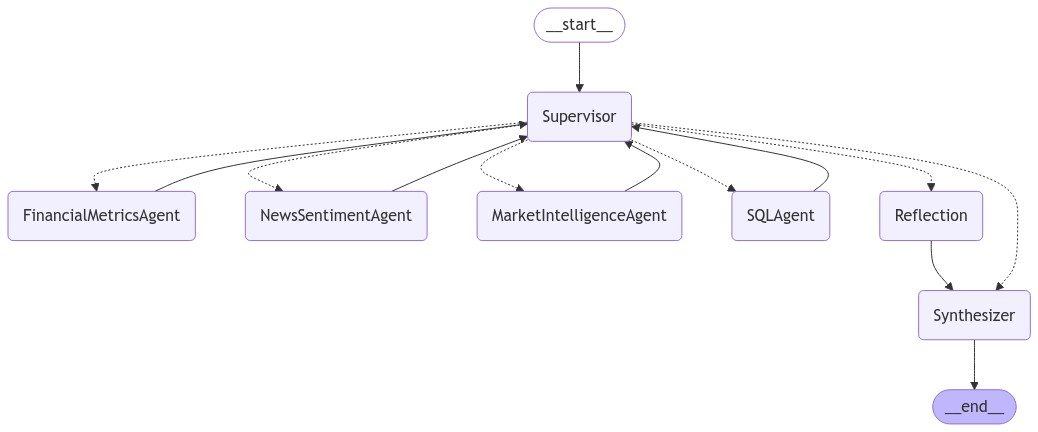

In [3]:
display(
    Image(
        agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

# Test 

In [ ]:
#Help me create a individual portfolio combining several good performing sectors willing to invest for over 5 years with high risk tolerance



In [8]:
# First, import required dependencies and set up environment variables
import os
from agents import define_graph
from typing import Dict, List, Any
from langchain.callbacks.base import BaseCallbackHandler
from langchain_openai import ChatOpenAI

# Set up your callback handler for monitoring agent progress
class ConsoleCallbackHandler(BaseCallbackHandler):
    def __init__(self):
        self.current_agent = ""
        self.verbose = False
        
    def write_agent_name(self, name: str):
        if self.verbose:
            self.current_agent = name
            print(f"\n{'='*50}")
            print(f"🤖 {name}")
            print(f"{'='*50}")
    
    def on_llm_start(self, serialized: Dict[str, Any], prompts: List[str], **kwargs: Any) -> None:
        if self.verbose:
            print(f"\n🤔 {self.current_agent} is thinking...")
    
    def on_llm_end(self, response, **kwargs: Any) -> None:
        if self.verbose:
            print(f"✅ {self.current_agent} has completed its task.")

# Function to test the agent
def test_agent(question: str, verbose: bool = False):
    """Run a test query through the agent"""
    callback = ConsoleCallbackHandler()
    callback.verbose = verbose
    
    # Configure the agent
    config = {
        "model": "gpt-4o-mini",  
        "temperature": 0,
        "streaming": True
    }
    
    # Create initial state
    initial_state = {
        "user_input": question,
        "messages": [],
        "next_step": "",
        "config": config,
        "callback": callback
    }
    
    # Get the workflow
    workflow = define_graph()
    
    # Run the agent
    response = workflow.invoke(initial_state)
    
    return response


In [9]:

# Test the agent
if __name__ == "__main__":
    # Example questions to test
    test_questions = [
        "What are the fundamentals of Apple (AAPL)?",
        "What is the current market sentiment for Tesla (TSLA)?",
        "Show me the latest financial metrics for Microsoft (MSFT)"
    ]
    
    # Run tests
    for question in test_questions:
        print(f"\n\nQuestion: {question}")
        print("-" * 50)
        response = test_agent(question, verbose=True)
        print("\nResponse:")
        print(response)



Question: What are the fundamentals of Apple (AAPL)?
--------------------------------------------------


KeyError: "Input to ChatPromptTemplate is missing variables {'agent_responses'}.  Expected: ['agent_responses', 'messages'] Received: ['messages']\nNote: if you intended {agent_responses} to be part of the string and not a variable, please escape it with double curly braces like: '{{agent_responses}}'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT"